In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff

#Text Preprocessing libraries
import nltk
nltk.download('stopwords')
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
import re 

#import contractions
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.svm import SVC
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn import preprocessing

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd

df = pd.read_json("/content/drive/My Drive/Sarcasm_Detection/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
#PreProcessing
df['headline']=df['headline'].str.lower()
# Remove the Hashtags from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove the links from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r"http\S+", "", x))
# Remove the Special characters from the text 
df['headline']=df['headline'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Substitute the multiple spaces with single spaces
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Remove all the single characters in the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the twitter handlers
df['headline']=df['headline'].apply(lambda x:re.sub('@[^\s]+','',x))

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['headline_clean'] = df['headline'].apply(remove_stopwords)
df.head()

,article_link,headline,is_sarcastic,headline_clean
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0,former versace store clerk sues secret black c...
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0,roseanne revival catches thorny political mood...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sonweb series closest thi...,1,mom starting fear sonweb series closest thing ...
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1,boehner wants wife listen come alternative deb...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jrowling wishes snape happy birthday in the mo...,0,jrowling wishes snape happy birthday magical way


In [ ]:
#Tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['headline_clean'].apply(lambda x: tokenization(x.lower()))
df.head()

,article_link,headline,is_sarcastic,headline_clean,tokenized
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0,former versace store clerk sues secret black c...,"[former, versace, store, clerk, sues, secret, ..."
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0,roseanne revival catches thorny political mood...,"[roseanne, revival, catches, thorny, political..."
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear sonweb series closest thi...,1,mom starting fear sonweb series closest thing ...,"[mom, starting, fear, sonweb, series, closest,..."
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1,boehner wants wife listen come alternative deb...,"[boehner, wants, wife, listen, come, alternati..."
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jrowling wishes snape happy birthday in the mo...,0,jrowling wishes snape happy birthday magical way,"[jrowling, wishes, snape, happy, birthday, mag..."


In [ ]:
#Print Sarcastic Headlines
sarcastic = df[df['is_sarcastic']==0]['headline_clean']
sarcastic[:10]

0     former versace store clerk sues secret black c...
1     roseanne revival catches thorny political mood...
4      jrowling wishes snape happy birthday magical way
5                                  advancing worldwomen
6                fascinating case eating lab grown meat
7                     ceo send kids school work company
9          fridaymorning email inside trumppresser ages
10    airline passengers tackle man rushes cockpit b...
11    facebook reportedly working healthcare feature...
12    north korea praises trump urges us voters reje...
Name: headline_clean, dtype: object

In [ ]:
#Print Non-Sarcastic Headlines
not_sarcastic = df[df['is_sarcastic']==1]['headline_clean']
not_sarcastic[:10]

2     mom starting fear sonweb series closest thing ...
3     boehner wants wife listen come alternative deb...
8     top snake handler leaves sinking huckabee camp...
15    nuclear bomb detonates rehearsal spider man mu...
16    cosby lawyer asks accusers didncome forward sm...
17       stock analysts confused frightened boar market
20       courtroom sketch artist clear manga influences
21    trump assures nation decision syrian airstrike...
27                               ex con back behind bar
28    careful consideration bush recommends oil dril...
Name: headline_clean, dtype: object

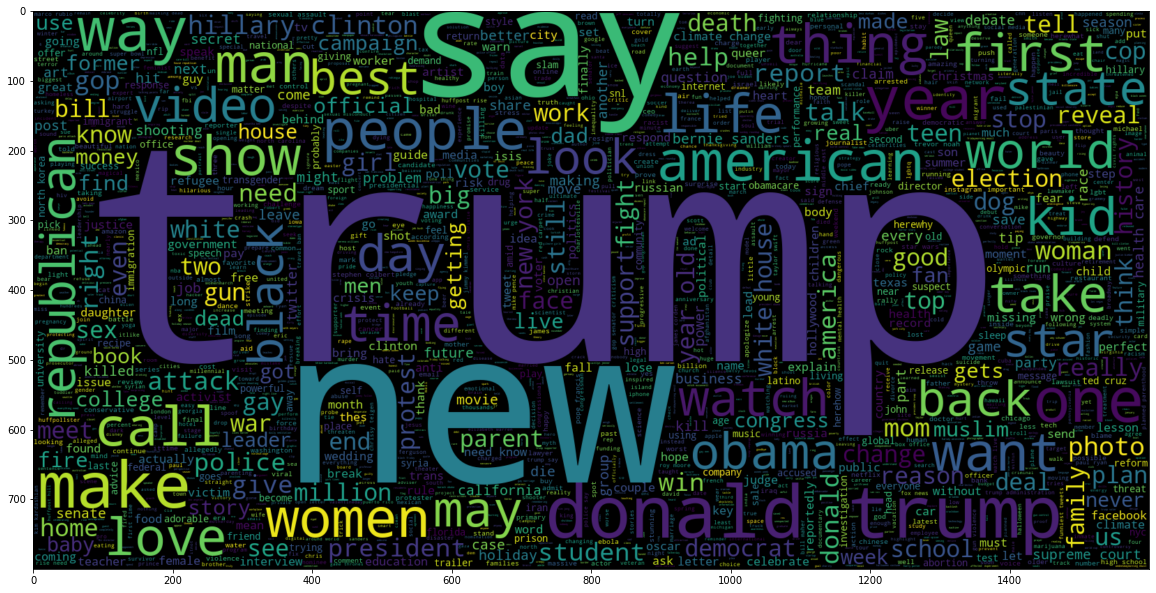

In [ ]:
#Wordcloud
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

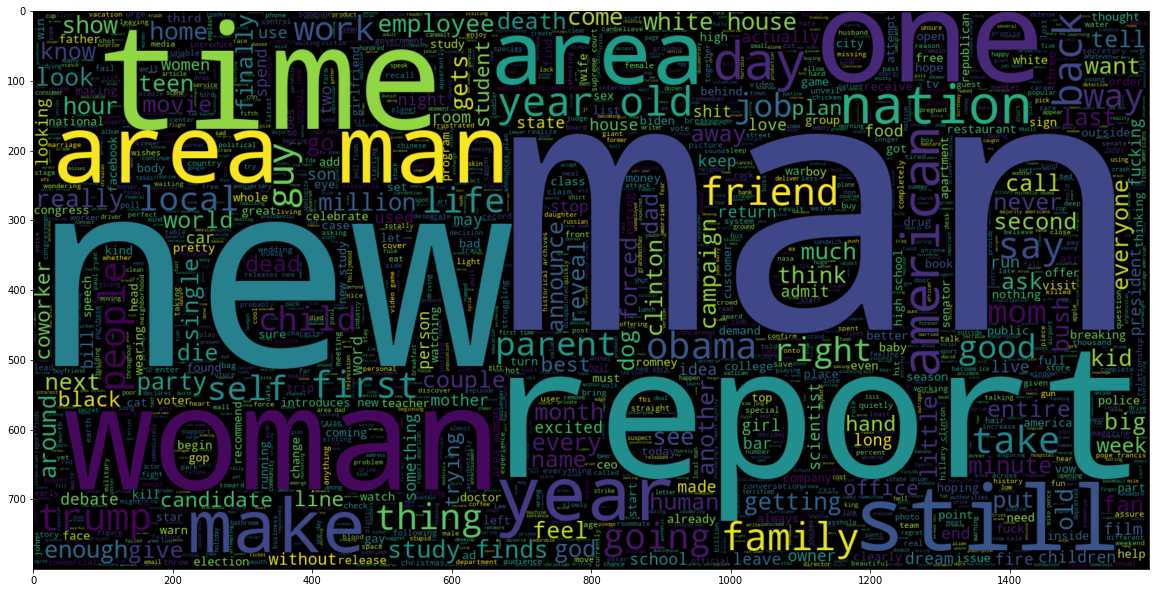

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
#Spliting it into training and testing 
X = df['headline_clean']
y = df['is_sarcastic']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.15,random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

22702 22702
4007 4007


In [ ]:
cv = CountVectorizer(ngram_range=(1,3))
X_train = cv.fit_transform(x_train)
X_test = cv.transform(x_test)

In [ ]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

SVM:train set
SVM:Confusion Matrix:  [[12704    24]
 [  406  9568]]
SVM:Accuracy : 98.10589375385429
SVM:Test set
SVM:Confusion Matrix:  [[2182   75]
 [1034  716]]
SVM:Accuracy :  72.32343399051659


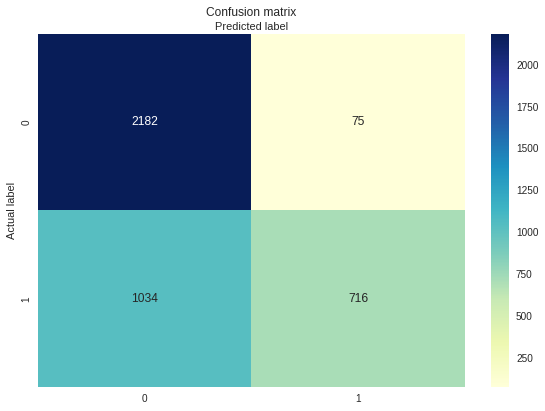

AUC: 0.86


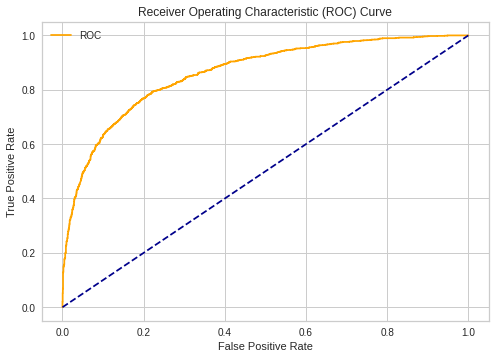

              precision    recall  f1-score   support

         Yes       0.68      0.97      0.80      2257
          No       0.91      0.41      0.56      1750

    accuracy                           0.72      4007
   macro avg       0.79      0.69      0.68      4007
weighted avg       0.78      0.72      0.70      4007



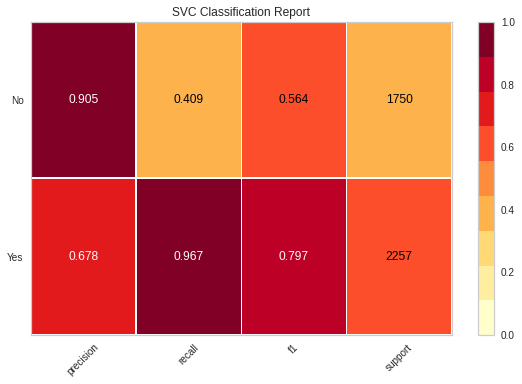

In [ ]:
#SVM
def Support_Vector(X_train,y_train,X_test,y_test):
  svm = SVC(probability=True)
  svm.fit(X_train,y_train)
  print("SVM:train set")
  y_pred = svm.predict(X_train)
  pred=svm.predict_proba(X_test)   
  print("SVM:Confusion Matrix: ", confusion_matrix(y_train, y_pred))
  print ("SVM:Accuracy :", accuracy_score(y_train,y_pred)*100)
  print("SVM:Test set")
  y_pred = svm.predict(X_test)
  print("SVM:Confusion Matrix: ", confusion_matrix(y_test, y_pred))
  print ("SVM:Accuracy : ", accuracy_score(y_test,y_pred)*100)
  #confusion Matrix
  matrix =confusion_matrix(y_test, y_pred)
  class_names=[0,1] 
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()
  #ROC_AUC curve
  probs = svm.predict_proba(X_test) 
  probs = probs[:, 1]  
  auc = roc_auc_score(y_test, probs)  
  print('AUC: %.2f' % auc)
  le = preprocessing.LabelEncoder()
  y_test1=le.fit_transform(y_test)
  fpr, tpr, thresholds = roc_curve(y_test1, probs)
  plot_roc_curve(fpr, tpr)
  #Classification Report
  target_names = ['Yes', 'No']
  prediction=svm.predict(X_test)
  print(classification_report(y_test, prediction, target_names=target_names))
  classes = ["Yes", "No"]
  visualizer = ClassificationReport(svm, classes=classes, support=True)
  visualizer.fit(X_train, y_train)  
  visualizer.score(X_test, y_test)  
  g = visualizer.poof()

Support_Vector(X_train,y_train,X_test,y_test)

DecisionTreeClassifier :train set
DecisionTreeClassifier :Confusion Matrix:  [[12728     0]
 [    0  9974]]
DecisionTreeClassifier :Accuracy :  100.0
DecisionTreeClassifierr :Test set
DecisionTreeClassifier :Confusion Matrix:  [[1793  464]
 [ 600 1150]]
DecisionTreeClassifier :Accuracy :  73.44646867981032


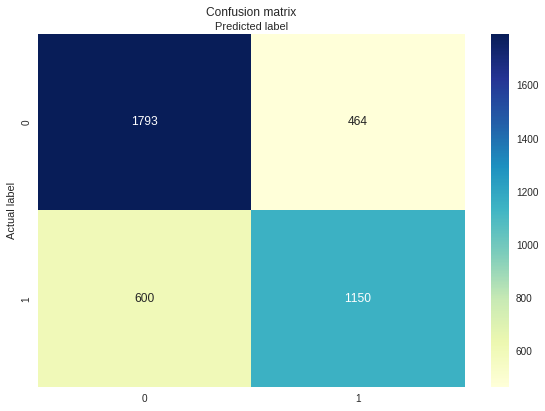

AUC: 0.73


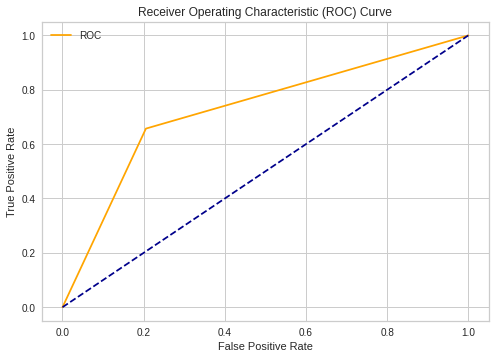

              precision    recall  f1-score   support

         Yes       0.75      0.79      0.77      2257
          No       0.71      0.66      0.68      1750

    accuracy                           0.73      4007
   macro avg       0.73      0.73      0.73      4007
weighted avg       0.73      0.73      0.73      4007



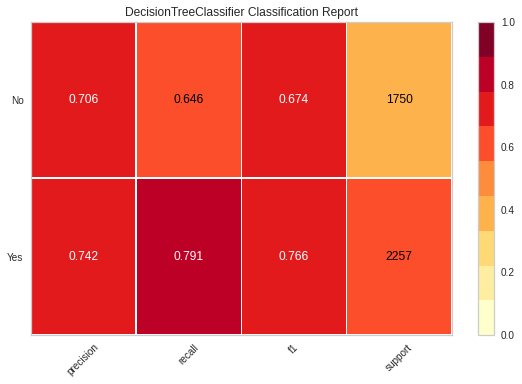

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#DecisionTreeClassifier
def DT(X_train,y_train,X_test,y_test):
  sc = DecisionTreeClassifier()  
  sc.fit(X_train,y_train)
  print("DecisionTreeClassifier :train set")
  y_pred = sc.predict(X_train)
  #pred=vc.predict_proba(X_test)   
  print("DecisionTreeClassifier :Confusion Matrix: ", confusion_matrix(y_train, y_pred))
  print ("DecisionTreeClassifier :Accuracy : ", accuracy_score(y_train,y_pred)*100)
  print("DecisionTreeClassifierr :Test set")
  y_pred = sc.predict(X_test)
  print("DecisionTreeClassifier :Confusion Matrix: ", confusion_matrix(y_test, y_pred))
  print ("DecisionTreeClassifier :Accuracy : ", accuracy_score(y_test,y_pred)*100)
  #confusion Matrix
  matrix =confusion_matrix(y_test, y_pred)
  class_names=[0,1] 
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()
  #ROC_AUC curve
  probs = sc.predict_proba(X_test) 
  probs = probs[:, 1]  
  auc = roc_auc_score(y_test, probs)  
  print('AUC: %.2f' % auc)
  le = preprocessing.LabelEncoder()
  y_test1=le.fit_transform(y_test)
  fpr, tpr, thresholds = roc_curve(y_test1, probs)
  plot_roc_curve(fpr, tpr)
  #Classification Report
  target_names = ['Yes', 'No']
  prediction=sc.predict(X_test)
  print(classification_report(y_test, prediction, target_names=target_names))
  classes = ["Yes", "No"]
  visualizer = ClassificationReport(sc, classes=classes, support=True)
  visualizer.fit(X_train, y_train)  
  visualizer.score(X_test, y_test)  
  g = visualizer.poof()

DT(X_train,y_train,X_test,y_test)